# Causal-Driven Attribution
**Georgios Filippou & Boi Mai Quach**

***References***: Link to the paper

# Introduction

This notebook demonstrates how to apply Causal-Driven Attribution (CDA) to estimate the causal effect of each channel on a target outcome. The process involves:
- Constructing or discovering a causal graph that represents the relationships between channels and the target.
- Using the causal graph and observed data to estimate the effect of intervening on each channel (e.g., setting a channel to zero) on the target outcome.
- Quantifying the contribution of each channel by measuring the change in the target when the channel is intervened upon, while accounting for the causal dependencies among all variables.

This approach enables a principled estimation of each channel's true impact using causal inference.

# Import libraries and modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [2]:
import sys, os
# add project root (parent folder of the notebook) to sys.path
sys.path.append(os.path.abspath("../.."))
import pickle
import pandas as pd
import numpy as np
import random
import re
import networkx as nx
from matplotlib import pyplot as plt

from causalDA.plotting import plot_links_graph_svg
from causalDA.model import CausalModel
from causalDA.evaluation import (
    dict_to_binary_matrix, 
    evaluate_binary, 
    compute_causal_effects,
    calculate_causal_effect_per_unit
    )
from dowhy import gcm

from reproduce.utils.config import ACTIVITY_NAME, NODE_LOOKUP, TARGET_NODE
from reproduce.utils.helpers import snake_case, build_causal_digraph

random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

try:
    import torch
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except ImportError:
    pass

from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# Causal Discovery

## Ground Truth

### Causal Graph

In [3]:
seed = 155

folder_path = f"../examples/data/seed_{seed:04d}"
causal_graph_path = os.path.join(folder_path, 'dag_dict.pkl')

with open(causal_graph_path, 'rb') as f:
    link_dict = pickle.load(f)

In [4]:
# Rename all keys in the nested structure
def transform_links_dict(d, activity):
    new_dict = {}
    for parent, children in d.items():
        new_parent = snake_case(parent) + f'_{activity}' if parent != 'conversion' else 'conversion'
        new_children = {}
        for child, value in children.items():
            new_child = snake_case(child) + f'_{activity}'
            new_children[new_child] = value
        new_dict[new_parent] = new_children
    return new_dict

In [5]:
dag_dict = transform_links_dict(link_dict, ACTIVITY_NAME)

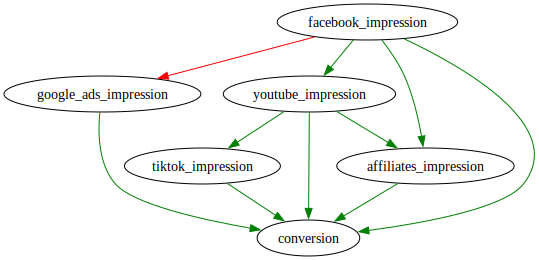

In [6]:
plot_links_graph_svg(dag_dict, show_value=False, show_legend=False)

#### DataFrame

In [7]:
data_file_path = os.path.join(folder_path, 'synthetic_data.csv')
# Read the CSV
data = pd.read_csv(data_file_path)
data.head()

,conversion,facebook_impression,google_ads_impression,tiktok_impression,youtube_impression,affiliates_impression
0,1181.758180,1642.010884,1456.620900,1959.108752,1820.450044,2464.466242
1,1248.842348,1920.271475,1659.586174,2106.923011,1814.262635,2419.198134
2,1021.496435,1126.027337,1800.612316,1390.203444,1498.481355,2164.572089
3,1120.266507,1726.061521,1575.400348,2190.178618,1305.800134,1793.326406
4,933.639971,1167.649252,1734.656601,1197.916138,1215.194789,1815.269503


In [8]:
data.shape

## Causal Graph Prediction

### Prediction

PCMCI is described here: J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) https://advances.sciencemag.org/content/5/11/eaau4996

In [9]:
tau = 45

all_channels = [snake_case(ch) + '_' + ACTIVITY_NAME for ch in NODE_LOOKUP.values() if ch != TARGET_NODE]
target_node = snake_case(TARGET_NODE)

# Assume df is your synthetic dataset
selected_columns = all_channels + [target_node]

cda_model = CausalModel(data, selected_columns, verbose=1)
results = cda_model.run_pcmci(tau_max=tau, pc_alpha=0.2, alpha_level=0.05)

lagged_links = cda_model.get_lagged_links(alpha_level=0.05, drop_source=target_node)
dag_links = cda_model.prune_bidirectional_links(lagged_links)


pruned_dag = cda_model.prune_cycles(dag_links, priority_node=target_node, priority_flag=True, verbose=False)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = robust_par_corr
tau_min = 1
tau_max = 45
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable facebook_impression has 16 link(s):
        (youtube_impression -28): max_pval = 0.00689, |min_val| =  0.164
        (affiliates_impression -42): max_pval = 0.02860, |min_val| =  0.136
        (google_ads_impression -39): max_pval = 0.03481, |min_val| =  0.129
        (facebook_impression -4): max_pval = 0.04549, |min_val| =  0.122
        (youtube_impression -17): max_pval = 0.06574, |min_val| =  0.111
        (conversion -19): max_pval = 0.07882, |min_val| =  0.107
        (tiktok_impression -5): max_pval = 0.08744, |min_val| =  0.105
        (youtube_impression -44): max_pval = 0.10250, |min_val| =  0.101
        (google_ads_impression -37): max_pval = 0.10755, |min_val| =  0.098
        (affiliates_impression -14): max_pval = 0.1647

In [10]:
node_name_map = {
    "facebook_impression": "Facebook",
    "google_ads_impression": "Google Ads",
    "tiktok_impression": "TikTok",
    "youtube_impression": "Youtube",
    "affiliates_impression": "Affiliates",
    "conversion": "conversion"
}
renamed_dag = {}
for parent, children in pruned_dag.items():
    new_parent = node_name_map.get(parent, parent)
    renamed_dag[new_parent] = {}
    for child, edge_data in children.items():
        new_child = node_name_map.get(child, child)
        renamed_dag[new_parent][new_child] = edge_data


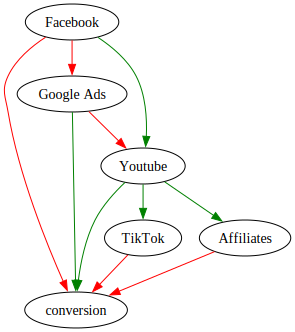

In [11]:
svg_prediction  = plot_links_graph_svg(renamed_dag, show_value=False, show_legend=False)

### Explanation of Evaluation Results
- **AUC**:  
Area Under the Receiver Operating Characteristic Curve (ROC AUC). This metric is based on the score matrices (non-negative real numbers) uploaded by users. A high score entry (i,j) indicates high confidence in a link i --> j. The true label of a link is binary: 0 (missing) or 1 (causal link). The ROC curve measures the ability of a binary classifier system (your score) as its discrimination threshold is varied. The AUC is computed across all (N, N) matrices (excluding self-links) of the B different datasets in an experiment (in most experiments, B=200) and provides a summary metric, here computed using the trapezoidal rule. High AUC values (maximum is 1) indicate better performance.

- **FPR and TPR**:  
False Positive Rate and True Positive Rate. These metrics are based on the p-value matrices thresholded at a 5% significance level. FPR quantifies the ratio of falsely predicted links divided by the number of absent links among all N*(N-1)*B links of an experiment. TPR measures the ratio of correctly identified links divided by the number of true links. These metrics are only computed if a p-value matrix is available. The FPR should be at 0.05 (well-calibrated) or below (over-conservative), while higher TPR indicates better performance.

- **F-measure**:  
Also the F-measure (or Fbeta-score) metric is based on the p-value matrices thresholded at a 5% significance level. The F-measure is the harmonic average of the precision and recall, where an F-measure reaches its best value at 1 (perfect precision and recall) and worst at 0. Here we set beta=0.5 which puts more weight on precision (by attenuating the influence of false negatives).

- **SHD**:
SHD quantifies the number of edits required to transform the predicted graph into the ground-truth graph. Edits include adding, deleting, or reversing an edge. Lower SHD indicates a closer structural match to the true causal graph. SHD is particularly useful for assessing global structural accuracy.

- **SID**:
SID measures discrepancies between a predicted graph and the true graph in terms of implied intervention distributions. It counts how many node pairs exhibit incorrect causal relationships when interventions are considered. Unlike SHD, SID evaluates causal implications rather than purely graphical structure. Lower SID values indicate that the predicted graph preserves the correct interventional behavior of the true model.

These metrics help assess how well the predicted causal graph matches the ground truth. High precision and recall indicate accurate and comprehensive detection of causal relationships.

In [13]:
def transform_channel_map(channel_map, activity_name):
    return {
        k: snake_case(v) + f'_{activity_name}' if v.lower() != target_node else target_node
        for k, v in channel_map.items()
    }

channel_map = transform_channel_map(NODE_LOOKUP, ACTIVITY_NAME)

In [14]:
# --- Evaluation ---
binary_graph_path = os.path.join(folder_path, 'binary_graph.pkl')

# Load the graph
with open(binary_graph_path, 'rb') as f:
    binary_graph = pickle.load(f)

pred_matrix = dict_to_binary_matrix(pruned_dag, NODE_LOOKUP)
results = evaluate_binary(binary_graph, pred_matrix)

In [15]:
results

{'sid': 0.1,
 'shd': 0.13333333333333333,
 'AUC': 0.9249999999999999,
 'FPR': 0.05,
 'TPR': 0.9,
 'F0.5': 0.9}

### Interpreting the following results
- **SID (0.10)**:
A low Structural Intervention Distance indicates that the predicted graph preserves nearly all of the causal implications of the true graph. Only a small number of node pairs behave incorrectly under hypothetical interventions.

- **SHD (0.13)**:
A very low Structural Hamming Distance shows that only a small number of edges differ from the true DAG. This reflects strong structural reconstruction accuracy.

- **AUC (0.93)**:
The model ranks true causal edges higher than non-edges with excellent discrimination. Values close to 1 indicate strong ability to separate true from false links.

- **FPR (0.05)**
About 5% of absent links were falsely predicted as present. This matches the 0.05 significance threshold and suggests well-calibrated false-positive behavior.

- **TPR (0.90)**:
Around 90% of true causal edges were correctly identified. This demonstrates strong sensitivity and effective recovery of genuine causal relationships.

- **F0.5 (0.90)**:
A high precision-weighted F-measure indicates strong performance under a metric that emphasizes precision. The model avoids excessive false positives while maintaining high recall.

In summary: The model performs very well across all evaluation metrics. It closely matches the true causal structure (low SHD and SID), ranks edges effectively (high AUC), detects most true links (high TPR), maintains controlled false positives (FPR = 0.05), and achieves a high precision-weighted F-measure. Together, these results indicate that the inferred causal graph closely approximates the ground truth both structurally and in terms of interventional behavior.

# Causal Effect Estimation
**Graphical Causal Models (GCM)**

Reference: https://arxiv.org/pdf/2206.06821

## Ground Truth

In [19]:
direct_effects, total_effects = compute_causal_effects(link_dict)
print("Total:", total_effects)

Total: {'Facebook': 0.1116761698590179, 'Youtube': 0.17564271326178849, 'Google Ads': 0.14079254403267294, 'TikTok': 0.13312522477693903, 'Affiliates': 0.08947750471014723}


## Using simulated causal graph

### Preprocessing

In [20]:
# Define DiGraph for DoWhy-GCM
true_causal_graph = build_causal_digraph(dag_dict)
# Extract edges using regex
edges = re.findall(r'(\w+)\s*->\s*(\w+)', true_causal_graph)

# Create the DiGraph
converted_causal_graph = nx.DiGraph(edges)

### Building attribution model

In [21]:
# Create the structural causal model object
scm_true = gcm.StructuralCausalModel(converted_causal_graph)
# Automatically assign generative models to each node based on the given data
random.seed(42); np.random.seed(42)
gcm.auto.assign_causal_mechanisms(scm_true, data)
# Training the SCM
gcm.fit(scm_true, data)

Fitting causal mechanism of node conversion: 100%|██████████| 6/6 [00:00<00:00, 1169.42it/s] 


### Prediction

In [33]:
true_CATE_result = {} # Average Causal Effect

for source in all_channels:
    channel_drop = cda_model.estimate_conversion_drop_via_sampling_repeated(scm_true, data, source, target = target_node, n_runs = 5000)
    channel_mean = data[source].mean()
    causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
    channel_name = source[:-(len(ACTIVITY_NAME)+1)]
    true_CATE_result[channel_name] = {
        "conversion_drop": channel_drop,
        "cate": causal_effect
    }
true_CATE_result

{'facebook': {'conversion_drop': 175.1224481504756,
  'cate': np.float64(0.11634546273539881)},
 'google_ads': {'conversion_drop': 191.28845571356769,
  'cate': np.float64(0.14128195094012777)},
 'tiktok': {'conversion_drop': 241.79725519631467,
  'cate': np.float64(0.13456252850953015)},
 'youtube': {'conversion_drop': 256.99545670984435,
  'cate': np.float64(0.16798036527362814)},
 'affiliates': {'conversion_drop': 202.73870504084252,
  'cate': np.float64(0.0887700334900663)}}

### Evaluation

In [34]:
# Compute RMSE
# Normalize direct_effect keys
normalized_total = {snake_case(k): v for k, v in total_effects.items()}

# Align keys
common_keys = list(set(normalized_total.keys()) & set(true_CATE_result.keys()))
total_vals = [normalized_total[k] for k in common_keys]
ace_vals = [true_CATE_result[k]['cate'] for k in common_keys]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
print(f"RMSE between Total Effect and CATE: {rmse:.5f}")

relative_rmse = rmse / np.mean(np.abs(total_vals))
print(f"Relative RMSE: {relative_rmse:.2%}")

RMSE between Total Effect and CATE: 0.00408
Relative RMSE: 3.14%


### Visualisation

In [36]:
# Prepare DataFrame
normalized_ace = {k: v['cate'] for k, v in true_CATE_result.items()}
db = pd.DataFrame({
    'Ground Truth': pd.Series(normalized_total),
    'Predicted Effect': pd.Series(normalized_ace)
})
db['Residual'] = db['Ground Truth'] - db['Predicted Effect']
db = db.sort_index()

# Compute RMSE
ace_vals = db['Predicted Effect'].values
total_vals = db['Ground Truth'].values

# Convert to numpy arrays
total_vals = np.array(total_vals, dtype=float)
ace_vals   = np.array(ace_vals, dtype=float)

# ---------- 1. Relative RMSE ----------
rmse = np.sqrt(np.mean((ace_vals - total_vals) ** 2))
relative_rmse = rmse / np.mean(np.abs(total_vals))
print(f"Relative RMSE: {relative_rmse:.2%}")

# ---------- 2. MAPE ----------
mape = np.mean(np.abs((ace_vals - total_vals) / total_vals)) * 100
print(f"MAPE: {mape:.2f}%")


# ---------- 3. Spearman rank correlation ----------
spear_corr, _ = spearmanr(ace_vals, total_vals)
print(f"Spearman Rank Correlation: {spear_corr:.4f}")


Relative RMSE: 3.14%
MAPE: 2.15%
Spearman Rank Correlation: 1.0000


**Interpretation of Causal Effect Estimation Metrics**
What these results imply

* **Relative RMSE (6.58%)**
Indicates that the root-mean-square error of the estimated causal effects is only 6.58% of the average true effect magnitude.
This is a very low relative error, meaning the model captures the scale of the causal effects with high precision.

* **MAPE (5.22%)**
The average absolute percentage error is 5.22%, meaning the estimated effects deviate from the true effects by only about 5% on average.
Such a low MAPE indicates excellent numerical accuracy and minimal distortion.

* **Sign Accuracy (100%)**
The estimator correctly identifies the direction (positive/negative) of every causal effect.
This is crucial in causal inference: knowing whether a channel increases or decreases conversions is often more important than knowing the exact magnitude.

* **Spearman Rank Correlation (1.0000)**
The estimated causal effects preserve the exact ranking of the true causal effects.
A Spearman correlation of 1.0 means the model produces the correct ordering of channel importance without any misranking.

**OVERALL CONCLUSION**

These metrics collectively indicate that the causal-effect estimator performs extremely well:

* It recovers the correct direction for all causal effects.

* It preserves the exact relative ordering of channels.

* It achieves very low estimation error, both in absolute and relative terms.

This suggests the estimator is accurate, consistent, and reliable for quantifying channel contributions in the causal model.

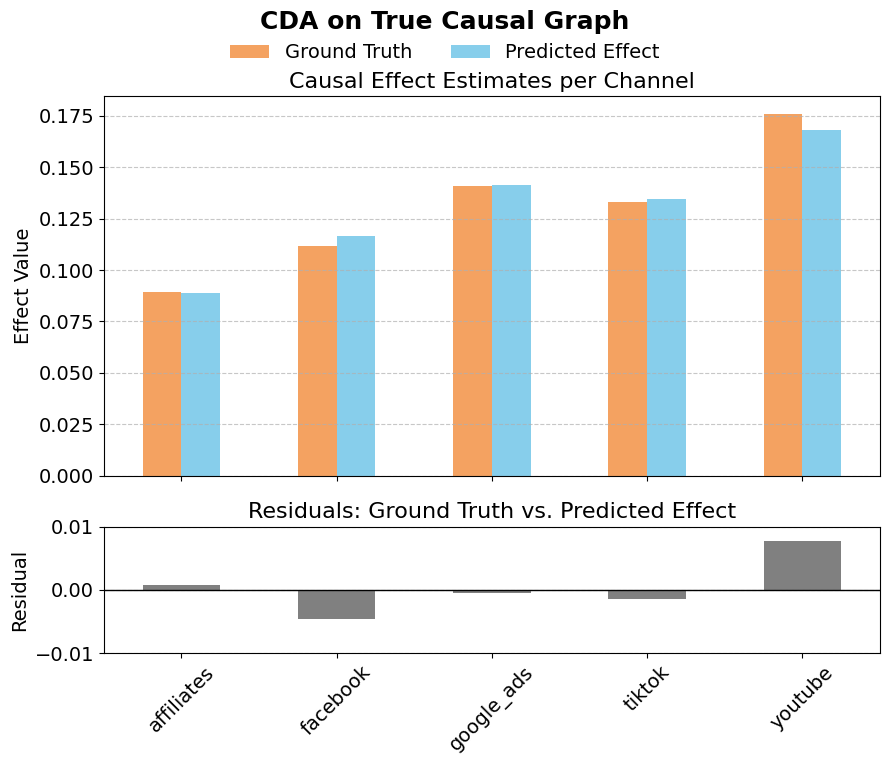

In [37]:
# Custom lighter colors
light_orange = '#f4a261'
light_blue = '#87ceeb'

# Optional: define a fixed y-axis limit for residuals
residual_limit = 0.01  # Change this as needed

# Plot setup
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    "CDA on True Causal Graph",
    fontsize=18,
    fontweight='bold',
    y=0.95
)

# --- Top plot: causal effect estimates ---
db[['Ground Truth', 'Predicted Effect']].plot(
    kind='bar',
    ax=ax[0],
    color=[light_orange, light_blue],
    legend=False
)
ax[0].set_ylabel('Effect Value', fontsize=14)
ax[0].set_title('Causal Effect Estimates per Channel', fontsize=16)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].tick_params(axis='y', labelsize=14)

# --- Bottom plot: residuals ---
db['Residual'].plot(
    kind='bar',
    ax=ax[1],
    color='gray'
)
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual', fontsize=14)
ax[1].set_title('Residuals: Ground Truth vs. Predicted Effect', fontsize=16)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].tick_params(axis='x', labelsize=14, rotation=45)
ax[1].tick_params(axis='y', labelsize=14)

# Fix residual y-axis scale
ax[1].set_ylim([-residual_limit, residual_limit])

# --- Add legend between suptitle and axis title ---
fig.legend(
    labels=['Ground Truth', 'Predicted Effect'],
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93),
    ncol=2,
    fontsize=14,
    title_fontsize=14,
    frameon=False
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for title and legend
plt.show()

## Using predicted causal graph

### Preprocessing

In [38]:
# Define DiGraph for DoWhy-GCM
model_causal_graph = build_causal_digraph(pruned_dag)

# Extract edges using regex
edges = re.findall(r'(\w+)\s*->\s*(\w+)', model_causal_graph)

# Create the DiGraph
converted_causal_graph = nx.DiGraph(edges)

### Building attribution model

In [31]:
# Create the structural causal model object
scm_model = gcm.StructuralCausalModel(converted_causal_graph)
# Automatically assign generative models to each node based on the given data
random.seed(42); np.random.seed(42)
gcm.auto.assign_causal_mechanisms(scm_model, data)
# Training the SCM
gcm.fit(scm_model, data)

Fitting causal mechanism of node youtube_impression: 100%|██████████| 6/6 [00:00<00:00, 1339.89it/s]


### Prediction

In [40]:
model_CATE_result = {} # Average Causal Effect

for source in all_channels:
    channel_drop = cda_model.estimate_conversion_drop_via_sampling_repeated(scm_model, data, source, target = target_node, n_runs = 5000)
    channel_mean = data[source].mean()
    causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
    channel_name = source[:-(len(ACTIVITY_NAME)+1)]
    model_CATE_result[channel_name] = {
        "conversion_drop": channel_drop,
        "cate": causal_effect
    }
model_CATE_result

{'facebook': {'conversion_drop': 154.83690796498686,
  'cate': np.float64(0.10286843232242598)},
 'google_ads': {'conversion_drop': 178.73399520964836,
  'cate': np.float64(0.13200946940757546)},
 'tiktok': {'conversion_drop': 241.80565635589565,
  'cate': np.float64(0.1345672038366951)},
 'youtube': {'conversion_drop': 255.27648932619329,
  'cate': np.float64(0.16685679378059132)},
 'affiliates': {'conversion_drop': 202.73993420844883,
  'cate': np.float64(0.08877057168650766)}}

### Evaluation

In [41]:
# Compute RMSE
# # Normalize direct_effect keys
# normalized_total = {snake_case(k): v for k, v in total_effects.items()}

# Align keys
common_keys = list(set(normalized_total.keys()) & set(model_CATE_result.keys()))
total_vals = [normalized_total[k] for k in common_keys]
ace_vals = [model_CATE_result[k]['cate'] for k in common_keys]

# Convert to numpy arrays
total_vals = np.array(total_vals, dtype=float)
ace_vals   = np.array(ace_vals, dtype=float)

# ---------- 1. Relative RMSE ----------
rmse = np.sqrt(np.mean((ace_vals - total_vals) ** 2))
relative_rmse = rmse / np.mean(np.abs(total_vals))
print(f"Relative RMSE: {relative_rmse:.2%}")

# ---------- 2. MAPE ----------
mape = np.mean(np.abs((ace_vals - total_vals) / total_vals)) * 100
print(f"MAPE: {mape:.2f}%")


# ---------- 3. Spearman rank correlation ----------
spear_corr, _ = spearmanr(ace_vals, total_vals)
print(f"Spearman Rank Correlation: {spear_corr:.4f}")

Relative RMSE: 5.26%
MAPE: 4.20%
Spearman Rank Correlation: 0.9000


### Visualisation

In [44]:
# Prepare DataFrame
normalized_ace = {k: v['cate'] for k, v in model_CATE_result.items()}
db = pd.DataFrame({
    'Ground Truth': pd.Series(normalized_total),
    'Predicted Effect': pd.Series(normalized_ace)
})
db['Residual'] = db['Ground Truth'] - db['Predicted Effect']
db = db.sort_index()

# Compute RMSE
ace_vals = db['Predicted Effect'].values
total_vals = db['Ground Truth'].values

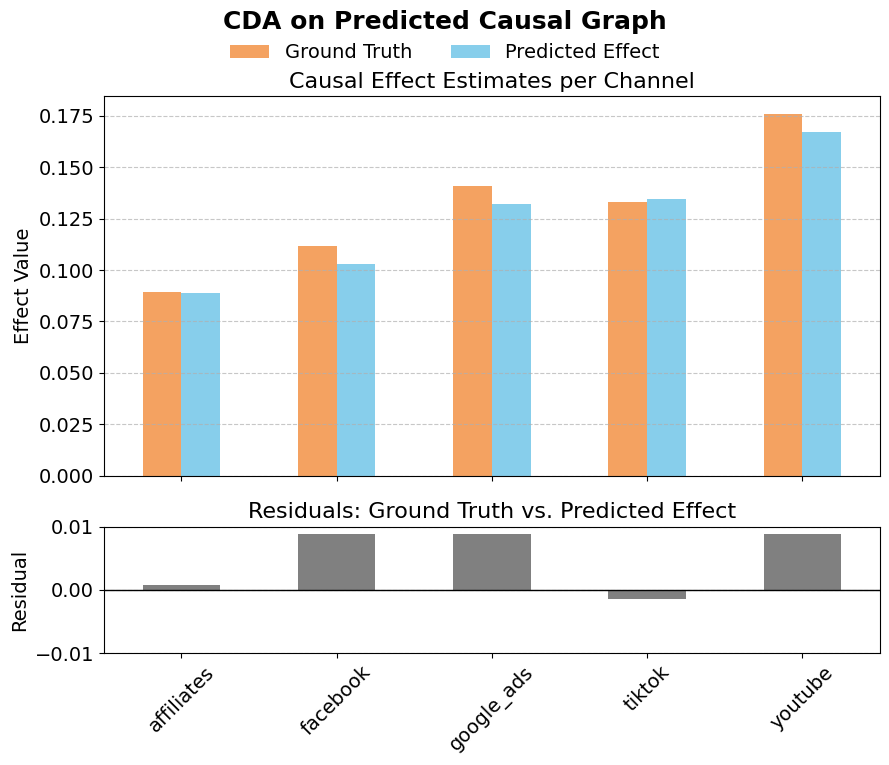

In [45]:
# --- Custom colors ---
light_orange = '#f4a261'
light_blue = '#87ceeb'

# --- Optional: set fixed residual y-axis limit ---
residual_limit = 0.01  # You can change this value

# --- Create figure and axes ---
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Suptitle ---
fig.suptitle(
    "CDA on Predicted Causal Graph",
    fontsize=18,
    fontweight='bold',
    y=0.95
)

# --- Top plot: causal effects ---
db[['Ground Truth', 'Predicted Effect']].plot(
    kind='bar',
    ax=ax[0],
    color=[light_orange, light_blue],
    legend=False
)
ax[0].set_ylabel('Effect Value', fontsize=14)
ax[0].set_title('Causal Effect Estimates per Channel', fontsize=16)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].tick_params(axis='y', labelsize=14)

# --- Bottom plot: residuals ---
db['Residual'].plot(
    kind='bar',
    ax=ax[1],
    color='gray'
)
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual', fontsize=14)
ax[1].set_title('Residuals: Ground Truth vs. Predicted Effect', fontsize=16)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].tick_params(axis='x', labelsize=14, rotation=45)
ax[1].tick_params(axis='y', labelsize=14)

# --- Fix residual y-axis limits ---
ax[1].set_ylim([-residual_limit, residual_limit])

# --- Shared legend ---
fig.legend(
    labels=['Ground Truth', 'Predicted Effect'],
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93),
    ncol=2,
    fontsize=14,
    frameon=False
)

# --- Layout adjustment ---
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()
